https://www.kaggle.com/datasets/dhruvildave/english-handwritten-characters-dataset

In [1]:
# Import Necessary Libraries

import tensorflow as tf
from tensorflow import keras
from keras_tuner import HyperModel, Hyperband
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
from PIL import Image
import os
from keras_tuner.tuners import Hyperband
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
import random as python_random
import datetime
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing.image import load_img

np.random.seed(33)
python_random.seed(33)
tf.random.set_seed(33)


In [2]:
# Load and Preprocess the Data

# Load the CSV with labels
label_file = '../data/english.csv'  # Update this path
df = pd.read_csv(label_file)

# Prepare image data
def load_images(image_folder, filenames, image_size):
    images = []
    for file in filenames:
        img_path = os.path.join(image_folder, file)
        img = Image.open(img_path).convert('L')  # Convert to grayscale
        img = img.resize(image_size)
        img_array = np.array(img)
        images.append(img_array)
    images = np.array(images) / 255.0  # Normalize images
    return images

# Update with your image folder path and image size
image_folder = '../data/'
image_size = (28, 28)  # Example size, adjust to your data
filenames = df['image'].tolist()  # Adjust 'filename' based on your CSV
images = load_images(image_folder, filenames, image_size)

# Prepare labels
num_classes = 62  # Update based on your dataset

# Create a mapping for the labels
label_mapping = {chr(i): i - 48 for i in range(48, 58)}  # '0'-'9', 0-9
label_mapping.update({chr(i): i - 65 + 10 for i in range(65, 91)})  # 'A'-'Z', 10-35
label_mapping.update({chr(i): i - 97 + 36 for i in range(97, 123)})  # 'a'-'z', 36-61

# Map the labels to integers
labels = df['label'].map(label_mapping).tolist()  # Adjust 'label' based on your CSV
labels = keras.utils.to_categorical(labels, num_classes)


In [3]:
print(labels.shape)
print(images.shape)

(3410, 62)
(3410, 28, 28)


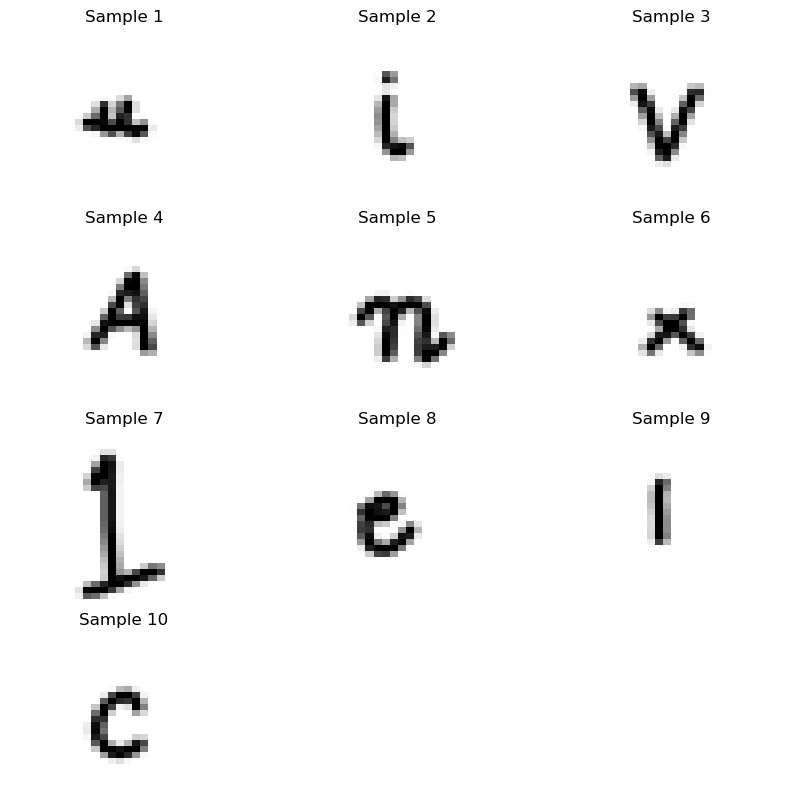

In [4]:
# Select random sample of image filenames
sample_filenames = np.random.choice(filenames, 10)

plt.figure(figsize=(10, 10))
for i, filename in enumerate(sample_filenames):
    # Create the full path to the image file
    img_path = os.path.join(image_folder, filename)
    
    # Load the image
    img = Image.open(img_path).convert('L')  # Convert to grayscale
    img = img.resize(image_size)  # Resize image
    
    # Plot the image
#    plt.figure(dpi=100)
    plt.subplot(4, 3, i+1)  # Create a subplot for each image
    plt.imshow(img, cmap='gray', aspect='auto')  
    plt.axis('off')  # Turn off axis labels
    plt.title('Sample {}'.format(i+1))  # Set the title for each image

plt.show()  # Display the plot



# NOTE: IMAGE QUALITY WENT DOWN (can try changing dpi above)!

In [5]:
# Split the data
X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.2)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1)

# Assuming your original images have shape (28, 28)
# Reshape the images to have a channels dimension
X_train = X_train.reshape((-1, 28, 28, 1))  # Add the channel dimension
X_val = X_val.reshape((-1, 28, 28, 1))
X_test = X_test.reshape((-1, 28, 28, 1))

In [6]:
X_train[0:2]


array([[[[1.],
         [1.],
         [1.],
         ...,
         [1.],
         [1.],
         [1.]],

        [[1.],
         [1.],
         [1.],
         ...,
         [1.],
         [1.],
         [1.]],

        [[1.],
         [1.],
         [1.],
         ...,
         [1.],
         [1.],
         [1.]],

        ...,

        [[1.],
         [1.],
         [1.],
         ...,
         [1.],
         [1.],
         [1.]],

        [[1.],
         [1.],
         [1.],
         ...,
         [1.],
         [1.],
         [1.]],

        [[1.],
         [1.],
         [1.],
         ...,
         [1.],
         [1.],
         [1.]]],


       [[[1.],
         [1.],
         [1.],
         ...,
         [1.],
         [1.],
         [1.]],

        [[1.],
         [1.],
         [1.],
         ...,
         [1.],
         [1.],
         [1.]],

        [[1.],
         [1.],
         [1.],
         ...,
         [1.],
         [1.],
         [1.]],

        ...,

        [[1.],
 

In [7]:
# Restart here


In [8]:
# Define the Model for Hyperparameter Tuning

def build_model(hp):
    model = Sequential()
    
    # First Convolutional Layer
    model.add(Conv2D(filters=hp.Int('conv_1_filter', min_value=32, max_value=128, step=16),
                     kernel_size=hp.Choice('conv_1_kernel', values=[3, 5]),
                     activation='relu',
                     input_shape=(28, 28, 1)))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    # Second Convolutional Layer
    model.add(Conv2D(filters=hp.Int('conv_2_filter', min_value=32, max_value=64, step=16),
                     kernel_size=hp.Choice('conv_2_kernel', values=[3, 5]),
                     activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    # Flatten and Dense Layers
    model.add(Flatten())
    model.add(Dense(units=hp.Int('dense_units', min_value=32, max_value=128, step=32),
                    activation='relu'))

    # Output Layer
    model.add(Dense(62, activation='softmax'))  # 62 classes

    return model


In [9]:


datagen = ImageDataGenerator(
    rotation_range=10,    # Rotate the image within 10 degrees range
    width_shift_range=0.10,  # Shift the pic width by a max of 10% of the width
    height_shift_range=0.10,  # Shift the pic height by a max of 10% of the height
    shear_range=0.10,     # Shear means cutting away part of the image (max 10%)
    zoom_range=0.10,      # Zoom in by 10% max
    horizontal_flip=False,  # Flipping might not be a good idea for character recognition
    fill_mode='nearest'   # Fill in missing pixels with the nearest filled value
)


In [10]:
# Keras Tuner for Hyperparameter Optimization

tuner = Hyperband(
    build_model,
    objective='val_accuracy',
    max_epochs=10,
    directory='keras_tuner_dir',
    project_name='character_recognition'
)

# Early Stopping Callback
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                  patience=7)

# Search for the best hyperparameters
tuner.search(X_train, 
             y_train,
             epochs=100,
             validation_data=(X_val, y_val),
             callbacks=[early_stopping])


Reloading Tuner from keras_tuner_dir\character_recognition\tuner0.json


In [11]:
# Get the best model
best_hp = tuner.get_best_hyperparameters()[0]
best_model = build_model(best_hp)


In [12]:
# TensorBoard Setup

log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir="./logs")



In [ ]:
# Compile the model

from tensorflow.keras.optimizers import SGD
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.optimizers import Adadelta
from tensorflow.keras.optimizers import Adagrad
from tensorflow.keras.optimizers import Nadam


final_epochs = 100  # Set the number of epochs for final training
best_model.compile(optimizer = Adadelta(rho=0.97, 
                                        epsilon=1e-07, 
                                        learning_rate=0.98), 
                   loss='categorical_crossentropy',
                   metrics=['accuracy'])


history = best_model.fit(
    datagen.flow(X_train, 
                 y_train, 
                 batch_size=32),
    steps_per_epoch=len(X_train) / 32,
    epochs=final_epochs,  # The maximum number of epochs
    validation_data=(X_val, y_val),
    callbacks=[early_stopping, tensorboard_callback]  # Add other callbacks if necessary
)


Epoch 1/100


76/76 [==============================] - 2s 15ms/step - loss: 4.1310 - accuracy: 0.0130 - val_loss: 4.1286 - val_accuracy: 0.0073
Epoch 2/100
76/76 [==============================] - 1s 13ms/step - loss: 4.1284 - accuracy: 0.0151 - val_loss: 4.1281 - val_accuracy: 0.0256
Epoch 3/100
76/76 [==============================] - 1s 13ms/step - loss: 4.1184 - accuracy: 0.0212 - val_loss: 4.0990 - val_accuracy: 0.0147
Epoch 4/100
76/76 [==============================] - 1s 12ms/step - loss: 3.9914 - accuracy: 0.0578 - val_loss: 3.6404 - val_accuracy: 0.0952
Epoch 5/100
76/76 [==============================] - 1s 13ms/step - loss: 3.5737 - accuracy: 0.1141 - val_loss: 2.7421 - val_accuracy: 0.2857
Epoch 6/100
76/76 [==============================] - 1s 13ms/step - loss: 2.9972 - accuracy: 0.2114 - val_loss: 2.3763 - val_accuracy: 0.3333
Epoch 7/100
76/76 [==============================] - 1s 13ms/step - loss: 2.4977 - accuracy: 0.3218 - val_loss: 1.9706 - val_accuracy: 0.4359
Epoc

In [ ]:
# Plot the training history

# Plot training & validation accuracy values
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')

plt.show()


In [ ]:
# Evaluate the model
loss, accuracy = best_model.evaluate(X_test, y_test)
print(f"Test Accuracy: {accuracy*100:.2f}%")


In [ ]:
# Saving and Loading the Model

# Save the model
best_model.save('character_recognition_model.h5')

# To load the model
loaded_model = tf.keras.models.load_model('character_recognition_model.h5')
